# Dynamic Programming

## Formulation
We treat each country’s year-to-year life-expectancy changes as a sequence of “rewards” (positive gains) and “penalties” (drops). Using dynamic programming, we find the single contiguous span of years whose summed rewards is maximal—i.e., the longest streak of uninterrupted improvement that yields the largest total increase in life expectancy.

## Application

For each country, compute the annual change in life expectancy:

```
delta[t] = LE[t+1] – LE[t]
```
Build an array dp[] where

```
dp[i] = max( delta[i], dp[i–1] + delta[i] )
```
so that dp[i] is the best total gain ending in year i.

Once dp[] is filled, the maximum entry is the country’s largest contiguous gain, and back-tracking from that index gives the start and end years.

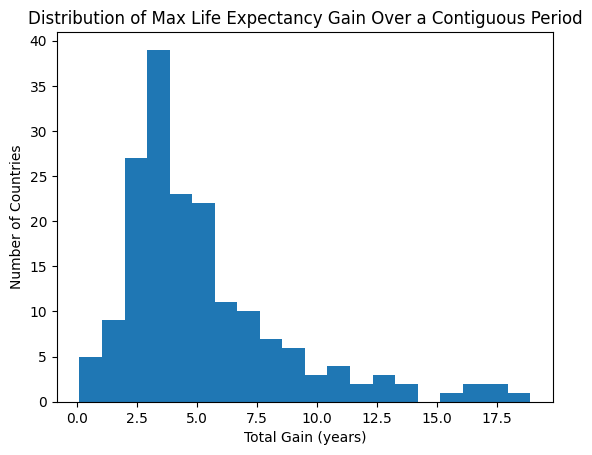

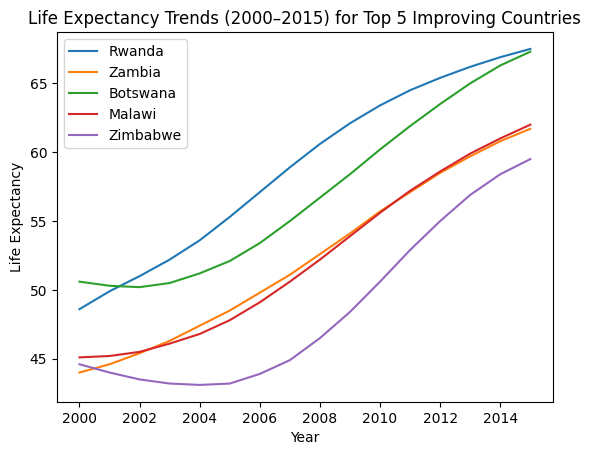

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('Life-Expectancy-Data-Updated.csv')

# 1) Compute improvement sequences for all countries using dynamic programming
# 1. Define subproblems precisely:
#    We want dp[i] = the maximum cumulative gain for a contiguous period ending at delta index i.
def find_best_improvement_sequence_dp(country):
    country_df = df[df['Country'] == country].sort_values('Year')
    years = list(country_df['Year'].values)
    le_values = list(country_df['Life_expectancy'].values)
    # Compute year-to-year changes (deltas): these are the rewards for subproblems
    deltas = [le_values[i+1] - le_values[i] for i in range(len(le_values)-1)]
    m = len(deltas)
    # Make an array to store subproblem results
    dp = [0] * m

    # 3. Base cases:
    #    The best contiguous gain ending at index 0 is just deltas[0]
    dp[0] = deltas[0]
    max_sum = dp[0]
    end_idx = 0

    # 4. Recurrence:
    #    Given dp[i-1], compute dp[i] = max(start new segment at i, extend previous segment to i)
    for i in range(1, m):
        dp[i] = max(deltas[i], dp[i-1] + deltas[i])
        # Track the overall maximum
        if dp[i] > max_sum:
            max_sum = dp[i]
            end_idx = i

    # 2. Answer:
    #    Once dp[] is full, max_sum in dp[end_idx] is the max contiguous gain.
    #    We backtrack to find start_idx for that segment.
    start_idx = end_idx
    while start_idx > 0 and dp[start_idx-1] + deltas[start_idx] == dp[start_idx]:
        start_idx -= 1

    return {
        'Country': country,
        'start_year': years[start_idx],
        'end_year': years[end_idx + 1],
        'total_gain': max_sum
    }

# Build the results for all countries
improvement_records = [find_best_improvement_sequence_dp(c) for c in df['Country'].unique()]
improvement_df = pd.DataFrame(improvement_records)


# 2) Generate plots

# a) Distribution of total_gain across countries
plt.figure()
plt.hist(improvement_df['total_gain'], bins=20)
plt.title('Distribution of Max Life Expectancy Gain Over a Contiguous Period')
plt.xlabel('Total Gain (years)')
plt.ylabel('Number of Countries')
plt.show()

# b) Line plots for top 5 countries by total_gain
top5 = improvement_df.sort_values('total_gain', ascending=False).head(5)['Country']
plt.figure()
for country in top5:
    country_df = df[df['Country'] == country].sort_values('Year')
    years = country_df['Year']
    le = country_df['Life_expectancy']
    plt.plot(years, le, label=country)
plt.title('Life Expectancy Trends (2000–2015) for Top 5 Improving Countries')
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
plt.legend()
plt.show()



## Insights
**1. Distribution of Max Life Expectancy Gain**

So first, that histogram shows how many years each country's best “run” added to life expectancy. Most countries only managed to gain around 2-6 years over their longest stretch of uninterrupted improvement.

There are a handful of outliers way out to the right - those are the countries that started really low and then shot up by 10-18 years in a row. But most are bunched in the middle.

This tells me that for the majority of countries, even their best DP-found segment only got them a few extra years, whereas a few low-starting countries got big jumps because they had more “low-hanging fruit” to pick.

**2. Top 5 Improving Countries (2000-2015)**

The line plot for Rwanda, Zambia, Botswana, Malawi, and Zimbabwe shows very steep, almost straight-line climbs. For example, Rwanda goes from about 49 in 2000 to ≈68 in 2015—that's almost a 19-year gain!

Zimbabwe actually dips a bit in the early 2000s (probably the HIV crisis), but then recovers and climbs steadily from 2004 onward.

Together, these visuals suggest a clear pattern:

Lower starting life expectancy → higher possible DP-found gains.

The biggest winners are those that had major health crises early on, then sustained multi-year interventions (child immunizations, HIV treatment scale-up, etc.), letting them rack up a long streak of positive deltas.

Meanwhile, countries already in the 70s or 80s for life expectancy only inch forward, so their best DP segment only nets a few years.